In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf
import re
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Model, load_model


In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [3]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [4]:
# check for missing values in python : https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b

print (project_data.isnull().sum())

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       3
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64


In [6]:
# dropna column pandas :https://stackoverflow.com/a/23235618/8363466
project_data = project_data[pd.notnull(project_data['teacher_prefix'])]

In [7]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [8]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [9]:
#merging all essays
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [10]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopword= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [11]:
def decontracted(phrase):
    """function for processing text data and removing unwanted characters"""
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"\\n", " ", phrase)
    phrase = re.sub(r"\\r", " ", phrase)
    phrase = re.sub(r"\\", " ", phrase)
    phrase = re.sub('[^A-Z0-9a-z]+', " ", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
project_data['project_grade_category'] =  project_data['project_grade_category'].str.replace(" ", "_")
project_data['project_grade_category'] =  project_data['project_grade_category'].str.replace("-", "_")
project_data['project_grade_category'].value_counts()

Grades_PreK_2    44225
Grades_3_5       37135
Grades_6_8       16923
Grades_9_12      10962
Name: project_grade_category, dtype: int64

In [13]:
project_data.columns
project_data.drop(['Unnamed: 0'], axis=1, inplace=True)


In [14]:
import re
digit_in_summary=[]
summary_array=project_data["project_resource_summary"].values
for i in summary_array:
    digit=re.search(r'\d', i)
    if (bool(digit)==False):
        digit_in_summary.append(0)
    else:
        digit_in_summary.append(1)
project_data["digit"]=digit_in_summary


In [15]:
project_data['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [16]:
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [17]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [18]:
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [19]:
project_data[project_data['teacher_number_of_previously_posted_projects']==project_data['teacher_number_of_previously_posted_projects'].max()]
# row of max value of teacher_number_of_previously_posted_projects row

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,digit,price,quantity
88012,p043212,fa2f220b537e8653fb48878ebb38044d,Mrs.,PA,2017-04-27 21:30:17,Grades_PreK_2,Food to Bring Home!,I currently have 25 six- and seven-year-old st...,I would love if my students could bring home f...,NaN,NaN,My students need Life Essential Healthy foods ...,451,1,Warmth Care_Hunger,Warmth Care_Hunger,I currently have 25 six- and seven-year-old st...,0,123.71,8


In [20]:
#TAKING FIRST ESSAY
project_row_0=project_data["essay"].values[0]
project_row_0

'My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \\r\\n\\r\\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\\"The limits of your language are the limits of your world.\\"-Ludwig Wittgenstein  Our English learner\'s have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\\r\\n\\r\\nBy providing these dvd\'s and players, st

In [21]:
import nltk
processed_phrase=decontracted(project_row_0)
processed_phrase#preprossed project_essay

'My students are English learners that are working on English as their second or third languages We are a melting pot of refugees immigrants and native born Americans bringing the gift of language to our school We have over 24 languages represented in our English Learner program with students at every level of mastery We also have over 40 countries represented with the families within our school Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures beliefs and respect The limits of your language are the limits of your world Ludwig Wittgenstein Our English learner s have a strong support system at home that begs for more resources Many times our parents are learning to read and speak English along side of their children Sometimes this creates barriers for parents to be able to help their child learn phonetics letter recognition and other reading skills By providing these dvd s and players students are able to continue their mastery of the Eng

In [22]:

#preprocess title 
#delete  "project_title" column and add preprocessed_titles
from tqdm import tqdm
preprocessed_titles=[]
for sentence in tqdm(project_data['project_title'].values):
    sent = decontracted(sentence)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopword)
    preprocessed_titles.append(sent.lower().strip())
project_data['preprocessed_title']=preprocessed_titles
project_data.drop('project_title', axis=1,inplace=True)


100%|███████████████████████████████████████████████████████████████████████| 109245/109245 [00:04<00:00, 24242.74it/s]


In [23]:
project_data['preprocessed_title'].head(5)

0          educational support english learners home
1                   wanted projector hungry learners
2    soccer equipment awesome middle school students
3                             techie kindergarteners
4                             interactive math tools
Name: preprocessed_title, dtype: object

In [24]:
preprocessed_essays=[]#preprocess essay column  and append to project_data
for sentence in tqdm(project_data['essay'].values):
    sent = decontracted(sentence)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopword)
    preprocessed_essays.append(sent.lower().strip())
project_data['preprocessed_essays']=preprocessed_essays
project_data.drop('essay', axis=1,inplace=True)

100%|████████████████████████████████████████████████████████████████████████| 109245/109245 [01:28<00:00, 1231.14it/s]


In [25]:
project_data.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'digit', 'price', 'quantity',
       'preprocessed_title', 'preprocessed_essays'],
      dtype='object')

In [26]:
#preprocessing school state converting to lowercase
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    15387
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3935
mi     3161
pa     3108
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

In [27]:
project_data.columns
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')


In [28]:
remove_col=['id','project_submitted_datetime','project_essay_1','project_essay_2','project_essay_3','project_essay_4',]

In [29]:
for col in remove_col:
    project_data.drop(col,axis=1,inplace=True)

project_data.columns

Index(['teacher_id', 'teacher_prefix', 'school_state',
       'project_grade_category', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'digit', 'price', 'quantity',
       'preprocessed_title', 'preprocessed_essays'],
      dtype='object')

In [30]:
resource_summary=[]#preprocess project_resource_summary column  and append to project_data
for sentence in tqdm(project_data["project_resource_summary"].values):
    sent = decontracted(sentence)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopword)
    resource_summary.append(sent.lower().strip())
project_data['resource_summary']=resource_summary
project_data.drop('project_resource_summary', axis=1,inplace=True)

100%|███████████████████████████████████████████████████████████████████████| 109245/109245 [00:09<00:00, 11172.05it/s]


In [31]:
project_data['resource_summary'].head(10)
project_data.drop('teacher_id',axis=1,inplace=True)


In [32]:
# check if we have any nan values are there
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

False
number of nan values 0


In [33]:
project_data["sum_integers"]=project_data['teacher_number_of_previously_posted_projects']  +\
                                    project_data['digit']  + \
                                    project_data['price'] + project_data['quantity'] 

In [34]:
#convert all columns to lowercase 
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['clean_subcategories'] = project_data['clean_subcategories'].str.lower()
project_data['clean_categories'] = project_data['clean_categories'].str.lower()

project_data.head(3)

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,digit,price,quantity,preprocessed_title,preprocessed_essays,resource_summary,sum_integers
0,mrs,in,grades_prek_2,0,0,literacy_language,esl literacy,0,154.60,23,educational support english learners home,students english learners working english seco...,students need opportunities practice beginning...,177.60
1,mr,fl,grades_6_8,7,1,history_civics health_sports,civics_government teamsports,0,299.00,1,wanted projector hungry learners,students arrive school eager learn polite gene...,students need projector help viewing education...,307.00
2,ms,az,grades_6_8,1,0,health_sports,health_wellness teamsports,0,516.85,22,soccer equipment awesome middle school students,true champions always ones win guts mia hamm q...,students need shine guards athletic socks socc...,539.85


In [35]:
#add total text to project_data
project_data['input_text'] = project_data['preprocessed_title'] + ' ' + project_data['preprocessed_essays'] + ' ' + project_data['resource_summary']

In [36]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X = project_data


In [37]:
#remove not useful columns

col=['digit','price','quantity','teacher_number_of_previously_posted_projects','preprocessed_essays','preprocessed_title','resource_summary']
for column in col:
    project_data.drop(column, axis=1, inplace=True)
project_data.head(5)
    

,teacher_prefix,school_state,project_grade_category,clean_categories,clean_subcategories,sum_integers,input_text
0,mrs,in,grades_prek_2,literacy_language,esl literacy,177.60,educational support english learners home stud...
1,mr,fl,grades_6_8,history_civics health_sports,civics_government teamsports,307.00,wanted projector hungry learners students arri...
2,ms,az,grades_6_8,health_sports,health_wellness teamsports,539.85,soccer equipment awesome middle school student...
3,mrs,ky,grades_prek_2,literacy_language math_science,literacy mathematics,240.90,techie kindergarteners work unique school fill...
4,mrs,tx,grades_prek_2,math_science,mathematics,72.98,interactive math tools second grade classroom ...


In [38]:
def for_train(data):
    c=CountVectorizer(lowercase=False)
    v=c.fit_transform(data)
    
    frequency=v.sum(axis=0).A1
    index=frequency.argsort()

    features=c.get_feature_names()
    rank_d={}
    count=1
    for item in index[::-1]:
        feature=features[item]
        rank_d[feature]=count
        count+=1
    return features,rank_d

        


In [40]:
def for_rest(data,d):
    #convert into tokens
    token_list=[]
    for sent in data:
        words = sent.split()
        token_sub = []
        for item in words:
            if(item in d):
                token_sub.append(d[item])

        token_list.append(token_sub)
    return token_list
    

In [41]:
features, dictio = for_train(project_data['school_state'])
print(features)
print(50 *"*")
print(dictio)
print(50 *"*")

tokenize_data = for_rest(project_data['school_state'], dictio)
print("state name:", project_data['school_state'][0])
print(50 *"*")

print("token value",tokenize_data[0])
print(50 *"*")


['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
**************************************************
{'ca': 1, 'tx': 2, 'ny': 3, 'fl': 4, 'nc': 5, 'il': 6, 'ga': 7, 'sc': 8, 'mi': 9, 'pa': 10, 'in': 11, 'mo': 12, 'oh': 13, 'la': 14, 'ma': 15, 'wa': 16, 'ok': 17, 'nj': 18, 'az': 19, 'va': 20, 'wi': 21, 'al': 22, 'ut': 23, 'tn': 24, 'ct': 25, 'md': 26, 'nv': 27, 'ms': 28, 'ky': 29, 'or': 30, 'mn': 31, 'co': 32, 'ar': 33, 'id': 34, 'ia': 35, 'ks': 36, 'nm': 37, 'dc': 38, 'hi': 39, 'me': 40, 'wv': 41, 'nh': 42, 'ak': 43, 'de': 44, 'ne': 45, 'sd': 46, 'ri': 47, 'mt': 48, 'nd': 49, 'wy': 50, 'vt': 51}
**************************************************
state name: in
**************************************************
token value [11]
******

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

print('Train Data Set', X_train.shape, y_train.shape)
print('Cross Validate Data Set', X_cv.shape, y_cv.shape)
print('Test Data Set', X_test.shape, y_test.shape)

Train Data Set (61176, 7) (61176,)
Cross Validate Data Set (15295, 7) (15295,)
Test Data Set (32774, 7) (32774,)


In [43]:
# - school_state : categorical data
(state_features, dictio) =for_train(X_train['school_state'].values)

X_train_state = for_rest(X_train['school_state'].values, dictio)
X_cv_state = for_rest(X_cv['school_state'].values, dictio)
X_test_state = for_rest(X_test['school_state'].values, dictio)

print(len(X_train_state), y_train.shape)
print(len(X_cv_state), y_cv.shape)
print(len(X_test_state), y_test.shape)
print(state_features)
print('*'*100)

61176 (61176,)
15295 (15295,)
32774 (32774,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
****************************************************************************************************


In [44]:
(teacher_features, dictio) =  for_train(X_train['teacher_prefix'].values)# Fit has to happen only on train data

X_train_teacher = for_rest(X_train['teacher_prefix'].values, dictio)
X_cv_teacher = for_rest(X_cv['teacher_prefix'].values, dictio)
X_test_teacher = for_rest(X_test['teacher_prefix'].values, dictio)

print(len(X_train_teacher), y_train.shape)
print(len(X_cv_teacher), y_cv.shape)
print(len(X_test_teacher), y_test.shape)
print(teacher_features)

print('*'*50)

61176 (61176,)
15295 (15295,)
32774 (32774,)
['dr', 'mr', 'mrs', 'ms', 'teacher']
**************************************************


In [45]:
# clean_categories : categorical data
(categories_features,dictio) =  for_train(X_train['clean_categories'].values)

X_train_categories = for_rest(X_train['clean_categories'].values,dictio)
X_cv_categories = for_rest(X_cv['clean_categories'].values, dictio)
X_test_categories = for_rest(X_test['clean_categories'].values, dictio)

print(len(X_train_categories), y_train.shape)
print(len(X_cv_categories), y_cv.shape)
print(len(X_test_categories), y_test.shape)
print(categories_features)
print('*'*50)

61176 (61176,)
15295 (15295,)
32774 (32774,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
**************************************************


In [46]:
# clean_subcategories : categorical data
(subcategories_features,dictio) =  for_train(X_train['clean_subcategories'].values)

X_train_subcategories = for_rest(X_train['clean_subcategories'].values,dictio)
X_cv_subcategories = for_rest(X_cv['clean_subcategories'].values, dictio)
X_test_subcategories = for_rest(X_test['clean_subcategories'].values, dictio)

print(len(X_train_subcategories), y_train.shape)
print(len(X_cv_subcategories), y_cv.shape)
print(len(X_test_subcategories), y_test.shape)
print(subcategories_features)
print('*'*50)

61176 (61176,)
15295 (15295,)
32774 (32774,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
**************************************************


In [47]:
# for project grade category
(grade_category_features, dictio) =  for_train(X_train['project_grade_category'].values)# Fit has to happen only on train data

X_train_grade = for_rest(X_train['project_grade_category'].values, dictio)
X_cv_grade = for_rest(X_cv['project_grade_category'].values, dictio)
X_test_grade = for_rest(X_test['project_grade_category'].values,dictio)

print(len(X_train_grade), y_train.shape)
print(len(X_cv_grade), y_cv.shape)
print(len(X_test_grade), y_test.shape)
print(grade_category_features)
print('*'*50)

61176 (61176,)
15295 (15295,)
32774 (32774,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
**************************************************


In [48]:
#find length of maximum essay length
maxlen=0
for i in X_train['input_text'].values:
    words=i.split()
    if len(words)> maxlen:
        maxlen=len(words)
maxlen

338

In [49]:
max_len=300
def padding(data,max_length):
    padded=pad_sequences(data,maxlen=max_length,padding='post')
    return padded
token=Tokenizer()
token.fit_on_texts(X_train['input_text'])
vocab_size=len(token.word_index)
seq1=token.texts_to_sequences(X_train["input_text"])
X_train_text=padding(seq1,max_len)
print(X_train_text.shape)

data2 = token.texts_to_sequences(X_cv['input_text'])
X_cv_text = padding(data2,max_len)
print(X_cv_text.shape)
data3= token.texts_to_sequences(X_test['input_text'])
X_test_text = padding(data3,max_len)
print(X_test_text.shape)

(61176, 300)
(15295, 300)
(32774, 300)


In [50]:
#padding other columns
X_train_state=padding(X_train_state,1)
X_test_state=padding(X_test_state,1)
X_cv_state=padding(X_cv_state,1)


X_train_grade=padding(X_train_grade,1)
X_test_grade=padding(X_test_grade,1)
X_cv_grade=padding(X_cv_grade,1)

X_train_cat=padding(X_train_categories,1)
X_test_cat=padding(X_test_categories,1)
X_cv_cat=padding(X_cv_categories,1)

X_train_sub=padding(X_train_subcategories,1)
X_test_sub=padding(X_test_subcategories,1)
X_cv_sub=padding(X_cv_subcategories,1)

X_train_teacher=padding(X_train_teacher,1)
X_test_teacher=padding(X_test_teacher,1)
X_cv_teacher=padding(X_cv_teacher,1)





In [51]:
print(X_train_text[2])


[25094     7    12   112   176     2   327     1    20    86   134   108
   202    48   783  1046    84   427  1507    61     5    20     2   132
     7    98     7   427    61    30   104  1046    80  1528   808    97
   116    97   140   156     4   146    14     8   427    14   515    69
    58    30    26     4    64  1067     3   675   138  1688    92   194
   427    61  2561    64  2238   347    62    22   297   426     7   320
    51   175    34  2148    77   463    38    17    22   250    22   426
   427   138     6     1  1554   427    61   451  1067    64    48    30
    30    20     2   208   651  1072     4   253    61   700    30    64
     2     4   368   159    11     1     3    69   138    64   451    58
    23     6   194    29    21    46   185     3   675   416  1688   194
   427    61  2561     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [51]:
print(X_train_text[2])

[ 7773   941  1159   294     2  1264   725     2   102   239 13623     1
   530   323  1147    32   113     2   239  4806     1  2801    62   159
  2696   986    41  1636    84    48   251    30   479   664     4     1
   482   692   116     7   854  2508   203   445   218     5    75   131
   160    39    19    92   636    24   100     7     1  4732   778   548
     4   941  1159   170   250   941  1159   590   186     2    69   941
  1159  1978   290    39   191  1331    39  1863   132  1897   219  3871
  1712  1004   198  2554  2253   228  2727   883  1126   980   680     1
     7   636   122    69    48   892  1149  3941  2950   917   941  1159
   524    50   199    49    39    11     1     3  9280  4783   714   423
  5287    69  1664    24     3   941  1159  3417  1832    43   392   282
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [52]:
embeddings_index = dict()
f = open('glove.6B.300d.txt.txt',encoding='utf8')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in token.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
print("Embedding_matrix_shape :",embedding_matrix.shape )
essay_matrix=embedding_matrix

Embedding_matrix_shape : (48399, 300)


In [53]:
#converting class labels to categorical variables
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_cv = to_categorical(y_cv)
y_test = to_categorical(y_test)

In [54]:
def auc_roc(y_true, y_pred):
    return tf.compat.v1.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [55]:
#input 1
#from keras.callbacks import Tensorboard
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint,EarlyStopping
from time import time
from tensorflow.python import keras
from keras.initializers import he_normal,glorot_normal
from keras.regularizers import l1,l2
from keras import regularizers
from keras import Model,Input
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape
from sklearn.metrics import roc_auc_score

input1=Input(shape=(300,))
y1=Embedding(vocab_size+1,output_dim=300,weights=[essay_matrix],trainable=False)(input1)
y1=LSTM(128,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(y1)
y1=Flatten()(y1)

input2 = Input(shape=(1,))
y2 = Embedding(input_dim= 52,output_dim= 2)(input2)
y2 = Flatten()(y2)

#input 3
input3 = Input(shape=(1,))
y3 = Embedding(input_dim= 5,output_dim= 2)(input3)
y3 = Flatten()(y3)

#input 4
input4 = Input(shape=(1,))
y4 = Embedding(input_dim=50,output_dim= 2)(input4)
y4 = Flatten()(y4)

#input 5
input5 = Input(shape=(1,))
y5 = Embedding(input_dim= 385,output_dim= 50)(input5)
y5 = Flatten()(y5)

#input 6
input6 = Input(shape=(1,))
y6 = Embedding(input_dim= 6,output_dim= 5)(input6)
y6 = Flatten()(y6)

#input 7
input7 = Input(shape=(1,))
y7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
#concat all inputs 
concatenate= concatenate([y1,y2,y3,y4,y5,y6,y7])

x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concatenate)
x=Dropout(0.6)(x)
x=BatchNormalization()(x)
x = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.6)(x)
output = Dense(2, activation = 'softmax')(x)

model = Model([input1,input2,input3,input4,input5,input6,input7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0003,decay = 1e-3),metrics=['accuracy',auc_roc])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     14519700    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [73]:
checkpoint=ModelCheckpoint('model_1.h5',monitor='val_accuracy',save_best_only=True,mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

callbacks=[checkpoint,earlystop,tensorboard]


In [74]:
model.fit([X_train_text,X_train_state,X_train_grade,X_train_cat,X_train_sub,
               X_train_teacher,X_train['sum_integers']], y_train, epochs=20,verbose=1,batch_size=128,validation_data=([X_cv_text,X_cv_state,X_cv_grade,X_cv_cat,X_cv_sub,X_cv_teacher,X_cv['sum_integers']]  , y_cv),callbacks =callbacks )

Epoch 1/20
 90/478 [====>.........................] - ETA: 25:22 - loss: 1.0363 - accuracy: 0.6806 - auc_roc: 0.5273

KeyboardInterrupt: 

Text(0, 0.5, 'IDF score')

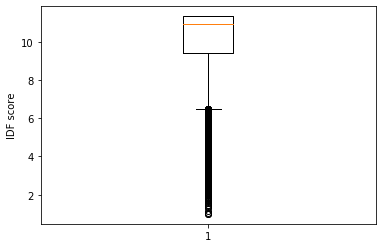

In [137]:
#MODEL-2
#tf-idf processed_essay
import matplotlib.pyplot as plt
tf_idf = TfidfVectorizer()
text = tf_idf.fit_transform(X_train["input_text"].values)
plt.boxplot(tf_idf.idf_)
plt.ylabel("IDF score")

In [138]:
#selecting values between 15th and 85th percentile idf score
print("The 15 percentile of idf score is :", np.percentile(tf_idf.idf_,[15]))
print("The 80 percentile of idf score is :",np.percentile(tf_idf.idf_,[80]))

The 15 percentile of idf score is : [8.21486409]
The 80 percentile of idf score is : [11.3283794]


In [142]:
a=np.percentile(tf_idf.idf_,[15])
b=np.percentile(tf_idf.idf_,[80])
feature_select=zip(tf_idf.get_feature_names(),tf_idf.idf_)
name=[]
for x,y in feature_select:
    if y>=a and y<=b:
        name.append(x)
    else:
        pass

In [148]:
print((name)[:2000])

['000s', '001', '002', '003', '005nannan', '00am', '00p', '00pm', '01', '010', '0125', '01ip', '02', '024', '025', '03', '030', '03074', '0315', '04', '04112016', '047', '05', '050', '05a', '05pm', '06', '060', '06ip', '07', '08', '084', '09', '0f', '0n', '0s', '0ver', '1000blackgirlbooks', '1001', '1009', '100ft', '100m', '100s', '100th', '1017', '102', '1020', '1022', '103', '1032', '1033', '104', '105', '1057', '106', '1065', '107', '1070', '108', '1080p', '1082', '1084', '109', '10k', '10lb', '10pk', '10pm', '10s', '10the', '10u', '10w', '10x', '10x10', '10yrs', '1100', '11000', '1104', '111', '111s', '112', '1120', '11242', '112th', '113', '113th', '114', '115', '116', '117', '118', '11e', '11pm', '11x14', '11x17', '11x25', '1200', '12000', '1201be', '1202', '1204', '120th', '121', '1212', '122', '122514', '123', '1233', '123s', '124', '1250', '126', '127', '1279', '128', '1285', '128gb', '129', '12bt', '12ft', '12inch', '12lb', '12pm', '12u', '12x', '12x16', '1300', '1307', '130i

In [150]:
def text_of_idf(data): #getting the text 
    preprocessed_text=[]
    for text in tqdm(data):
        words=text.split()
        final_text=''
        for word in words:
            if word in name:
                final_text+=' '+ word
        preprocessed_text.append(final_text)
    return preprocessed_text


In [152]:
X_train_essay=text_of_idf(X_train['input_text'])
len(X_train_essay)

100%|██████████████████████████████████████████████████████████████████████████| 61176/61176 [1:35:34<00:00, 10.67it/s]


61176

In [153]:
X_test_essay=text_of_idf(X_test['input_text'])
X_cv_essay=text_of_idf(X_cv['input_text'])
print(len(X_test_essay))
print(len(X_cv_essay))


100%|████████████████████████████████████████████████████████████████████████████| 15295/15295 [20:54<00:00, 12.19it/s]

32774
15295


In [154]:
token=Tokenizer()
token.fit_on_texts(X_train_essay)
vocab_size_2=len(token.word_index) + 1
doc1=token.texts_to_sequences(X_train_essay)
X_train_essay=padding(doc1,max_len)
doc2 = token.texts_to_sequences(X_cv_essay)
X_cv_essay = padding(doc2,max_len)
doc3 = token.texts_to_sequences(X_test_essay)
X_test_essay = padding(doc3,max_len)

In [155]:
embedding_matrix_2 = np.zeros((vocab_size_2, 300))
for word, i in token.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix_2[i] = embedding_vector

In [156]:
X_train_embedding_matrix=embedding_matrix_2
X_train_embedding_matrix.shape

(41285, 300)

In [159]:
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape

input1=Input(shape=(300,))
y1=Embedding(41285,output_dim=300,weights=[X_train_embedding_matrix],trainable=False)(input1)
y1=LSTM(128,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(y1)
y1=Flatten()(y1)

input2 = Input(shape=(1,))
y2 = Embedding(input_dim= 52,output_dim= 2)(input2)
y2 = Flatten()(y2)

#input 3
input3 = Input(shape=(1,))
y3 = Embedding(input_dim= 5,output_dim= 2)(input3)
y3 = Flatten()(y3)

#input 4
input4 = Input(shape=(1,))
y4 = Embedding(input_dim=50,output_dim= 2)(input4)
y4 = Flatten()(y4)

#input 5
input5 = Input(shape=(1,))
y5 = Embedding(input_dim= 385,output_dim= 50)(input5)
y5 = Flatten()(y5)

#input 6
input6 = Input(shape=(1,))
y6 = Embedding(input_dim= 6,output_dim= 5)(input6)
y6 = Flatten()(y6)

#input 7
input7 = Input(shape=(1,))
y7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
#concat all inputs 
concatenate= concatenate([y1,y2,y3,y4,y5,y6,y7])

x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concatenate)
x=Dropout(0.6)(x)
x=BatchNormalization()(x)
x = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.6)(x)
output = Dense(2, activation = 'softmax')(x)

model = Model([input1,input2,input3,input4,input5,input6,input7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0003,decay = 1e-3),metrics=['accuracy',auc_roc])
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_37 (Embedding)        (None, 300, 300)     12385500    input_44[0][0]                   
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [68]:
checkpoint=ModelCheckpoint('model_2.h5',monitor='val_accuracy',save_best_only=True,mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

callbacks_2=[checkpoint,earlystop,tensorboard]


In [162]:
model.fit([X_train_essay,X_train_state,X_train_grade,X_train_cat,X_train_sub,
               X_train_teacher,X_train['sum_integers']], y_train, epochs=20,verbose=1,batch_size=128,validation_data=([X_cv_essay,X_cv_state,X_cv_grade,X_cv_cat,X_cv_sub,X_cv_teacher,X_cv['sum_integers']]  , y_cv),callbacks =callbacks_2 )

Epoch 1/20
478/478 [==============================] - 2107s 4s/step - loss: 0.7143 - accuracy: 0.7423 - auc_roc: 0.5232 - val_loss: 0.5041 - val_accuracy: 0.8486 - val_auc_roc: 0.5867
Epoch 2/20
478/478 [==============================] - 1251s 3s/step - loss: 0.5154 - accuracy: 0.8288 - auc_roc: 0.5416 - val_loss: 0.4504 - val_accuracy: 0.8486 - val_auc_roc: 0.6004
Epoch 3/20
324/478 [===================>..........] - ETA: 6:41 - loss: 0.4890 - accuracy: 0.8436 - auc_roc: 0.5443

KeyboardInterrupt: 

In [ ]:
#model 3
#reusing embedding of text data of model_1 

In [57]:
vector=CountVectorizer()
vector.fit(X_train['school_state'].values)
X_train_school_state=vector.transform(X_train['school_state'].values)
X_cv_school_state=vector.transform(X_cv['school_state'].values)
X_test_school_state=vector.transform(X_test['school_state'].values)
feature_names=vector.get_feature_names()

print(X_train_school_state.shape, y_train.shape)
print(X_cv_school_state.shape, y_cv.shape)
print(X_test_school_state.shape, y_test.shape)
print(feature_names)
print("*" *50)

(61176, 51) (61176, 2)
(15295, 51) (15295, 2)
(32774, 51) (32774, 2)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
**************************************************


In [58]:
vector=CountVectorizer()
vector.fit(X_train['teacher_prefix'].values)
X_train_teacher=vector.transform(X_train['teacher_prefix'].values)
X_cv_teacher=vector.transform(X_cv['teacher_prefix'].values)
X_test_teacher=vector.transform(X_test['teacher_prefix'].values)
feature_names=vector.get_feature_names()

print(X_train_teacher.shape, y_train.shape)
print(X_cv_teacher.shape, y_cv.shape)
print(X_test_teacher.shape, y_test.shape)
print(feature_names)
print("*" *50)

(61176, 5) (61176, 2)
(15295, 5) (15295, 2)
(32774, 5) (32774, 2)
['dr', 'mr', 'mrs', 'ms', 'teacher']
**************************************************


In [59]:
vector=CountVectorizer()
vector.fit(X_train['project_grade_category'].values)
X_train_grade=vector.transform(X_train['project_grade_category'].values)
X_cv_grade=vector.transform(X_cv['project_grade_category'].values)
X_test_grade=vector.transform(X_test['project_grade_category'].values)
feature_names=vector.get_feature_names()

print(X_train_grade.shape, y_train.shape)
print(X_cv_grade.shape, y_cv.shape)
print(X_test_grade.shape, y_test.shape)
print(feature_names)
print("*" *50)

(61176, 4) (61176, 2)
(15295, 4) (15295, 2)
(32774, 4) (32774, 2)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
**************************************************


In [60]:
vector=CountVectorizer()
vector.fit(X_train['clean_categories'].values)
X_train_cat=vector.transform(X_train['clean_categories'].values)
X_cv_cat=vector.transform(X_cv['clean_categories'].values)
X_test_cat=vector.transform(X_test['clean_categories'].values)
feature_names=vector.get_feature_names()

print(X_train_cat.shape, y_train.shape)
print(X_cv_cat.shape, y_cv.shape)
print(X_test_cat.shape, y_test.shape)
print(feature_names)
print("*" *50)

(61176, 9) (61176, 2)
(15295, 9) (15295, 2)
(32774, 9) (32774, 2)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
**************************************************


In [61]:
vector=CountVectorizer()
vector.fit(X_train['clean_subcategories'].values)
X_train_sub=vector.transform(X_train['clean_subcategories'].values)
X_cv_sub=vector.transform(X_cv['clean_subcategories'].values)
X_test_sub=vector.transform(X_test['clean_subcategories'].values)
feature_names=vector.get_feature_names()

print(X_train_sub.shape, y_train.shape)
print(X_cv_sub.shape, y_cv.shape)
print(X_test_sub.shape, y_test.shape)
print(feature_names)
print("*" *50)

(61176, 30) (61176, 2)
(15295, 30) (15295, 2)
(32774, 30) (32774, 2)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
**************************************************


In [62]:
X_train_digit = X_train['sum_integers'].values.reshape(-1,1)
X_cv_digit = X_cv['sum_integers'].values.reshape(-1,1)
X_test_digit = X_test['sum_integers'].values.reshape(-1,1)


In [91]:
from scipy.sparse import hstack
whole_train = hstack([X_train_teacher,X_train_school_state,X_train_grade,X_train_sub,X_train_cat,X_train_digit]).todense()
whole_cv = hstack([X_cv_teacher,X_cv_school_state,X_cv_grade,X_cv_sub,X_cv_cat,X_cv_digit]).todense()

X_train_3 = np.resize(whole_train,new_shape=(whole_train.shape[0],99,1))
X_cv_3 = np.resize(whole_cv,new_shape=(whole_cv.shape[0],99,1))

In [92]:
X_train_3.shape

(61176, 99, 1)

In [88]:
# input 1
tf.compat.v1.disable_eager_execution()
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape
from keras.layers import LeakyReLU
input1 = Input(batch_shape=(None,300))
x1 = Embedding(input_dim=48399,output_dim= 300,weights=[essay_matrix],trainable = False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(256,return_sequences=True)(x1)
x1 = Flatten()(x1)

# input 2
input2 = Input(shape=(99,1))
x2 = tf.keras.layers.Conv1D(filters=64,kernel_size=3,strides=1)(input2)
x2 = tf.keras.layers.Conv1D(filters=64,kernel_size=3,strides=1)(x2)
x2 = Flatten()(x2)

# merging both the inputs
concat = concatenate([x1,x2])
x = Dense(512,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.4)(x)
x = LeakyReLU()(x)
x = Dense(256,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.6)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with two inputs
model = Model([input1,input2], output)
model.run_eagerly = True
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.adam(lr=0.0003,decay = 1e-3), metrics=['accuracy', auc_roc])
print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 300, 300)     14519700    input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 99, 1)]      0                                            
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 300, 300)     0           embedding_8[0][0]                
____________________________________________________________________________________________

In [89]:
print(X_train_text.shape)
print(train_data.shape)


(61176, 300)
(61176, 50, 1)


In [93]:
model.fit([X_train_text, X_train_3], y_train, epochs=50, verbose=1, batch_size=256, validation_data=([X_cv_text, X_cv_3]  , y_cv), callbacks = callbacks_2)
  

Train on 61176 samples, validate on 15295 samples
Epoch 1/50
61176/61176 [==============================] - 1957s 32ms/sample - loss: 0.5890 - accuracy: 0.8421 - auc_roc: 0.5685 - val_loss: 0.6149 - val_accuracy: 0.8439 - val_auc_roc: 0.6524
Epoch 2/50
61176/61176 [==============================] - 2620s 43ms/sample - loss: 0.5088 - accuracy: 0.8480 - auc_roc: 0.6545 - val_loss: 0.5423 - val_accuracy: 0.8501 - val_auc_roc: 0.6943
Epoch 3/50
61176/61176 [==============================] - 3369s 55ms/sample - loss: 0.4895 - accuracy: 0.8483 - auc_roc: 0.6778 - val_loss: 0.5080 - val_accuracy: 0.8516 - val_auc_roc: 0.7036
Epoch 4/50
61176/61176 [==============================] - 7641s 125ms/sample - loss: 0.4813 - accuracy: 0.8489 - auc_roc: 0.6904 - val_loss: 0.5277 - val_accuracy: 0.8528 - val_auc_roc: 0.7176
Epoch 5/50
61176/61176 [==============================] - 5414s 88ms/sample - loss: 0.4725 - accuracy: 0.8509 - auc_roc: 0.7035 - val_loss: 0.5258 - val_accuracy: 0.8483 - val_auc_r

(61176, 50)